In [2]:
# Import required libraries
from transformers import BertTokenizer, BertModel, __version__ as transformers_version
import torch
from typing import List, Tuple
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
# Enable inline plotting for Jupyter
%matplotlib inline  

print("=== Library Versions ===")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers_version}")

=== Library Versions ===
PyTorch version: 2.2.2
Transformers version: 4.49.0


In [3]:
def format_attention_shapes(attention_weights: List[torch.Tensor]) -> List[Tuple]:
    """Format attention weights into readable tuples. Every tensor is the attention weight per layer"""
    # Attention Weight Shape shall be (1, 12, 12, 12);
    # Batch Size = 1 for one sentence, skiped here.
    # Number of Heads = 12 BERT base has 12 Attention Heads；
    # Sequence Length = 12 The sentence is tokenized to 12 Tokens, include [CLS] and [SEP]
    # Add the layer number, it returns:
    # [
    # (1, 12, 12, 12),
    # (2, 12, 12, 12),
    # ...,
    # (12, 12, 12, 12)
    # ]

    shapes = []
    for layer_idx, attn in enumerate(attention_weights):
        shape = (layer_idx + 1, *attn.shape[1:])
        shapes.append(shape)
    return shapes

def build_graph(attention_matrix, tokens, threshold=0.1):
    """Build attention visualization graph."""

    # Nodes are tokens.
    # Edges are where the attention weight > threshold
    
    G = nx.DiGraph()
    G.add_nodes_from(tokens)
    
    for i, src in enumerate(tokens):
        for j, tgt in enumerate(tokens):
            weight = float(attention_matrix[i, j])  # Convert to float for visualization
            if weight > threshold:
                G.add_edge(src, tgt, weight=round(weight, 3))
    return G

def visualize_attention(G, title="Attention Visualization"):
    """Visualize attention graph."""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw the graph
    nx.draw(G, pos, 
            with_labels=True,
            node_color='lightblue',
            node_size=2000,
            font_size=10,
            font_weight='bold',
            arrows=True,
            edge_color='gray',
            width=1)
    
    # Add edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
# Initialize model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained(
    'bert-base-uncased',
    output_attentions=True,
    attn_implementation="eager"
)

# Input sentence
sentence = "The cat that the dog chased sat on the mat."
tokens = tokenizer(sentence, return_tensors='pt')

# Get attention weights
outputs = model(**tokens)
attention_weights = outputs.attentions

# Print token information
tokens_list = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
print("\nInput sentence:", sentence)
print("\nTokenized text:", tokens_list)


Input sentence: The cat that the dog chased sat on the mat.

Tokenized text: ['[CLS]', 'the', 'cat', 'that', 'the', 'dog', 'chased', 'sat', 'on', 'the', 'mat', '.', '[SEP]']


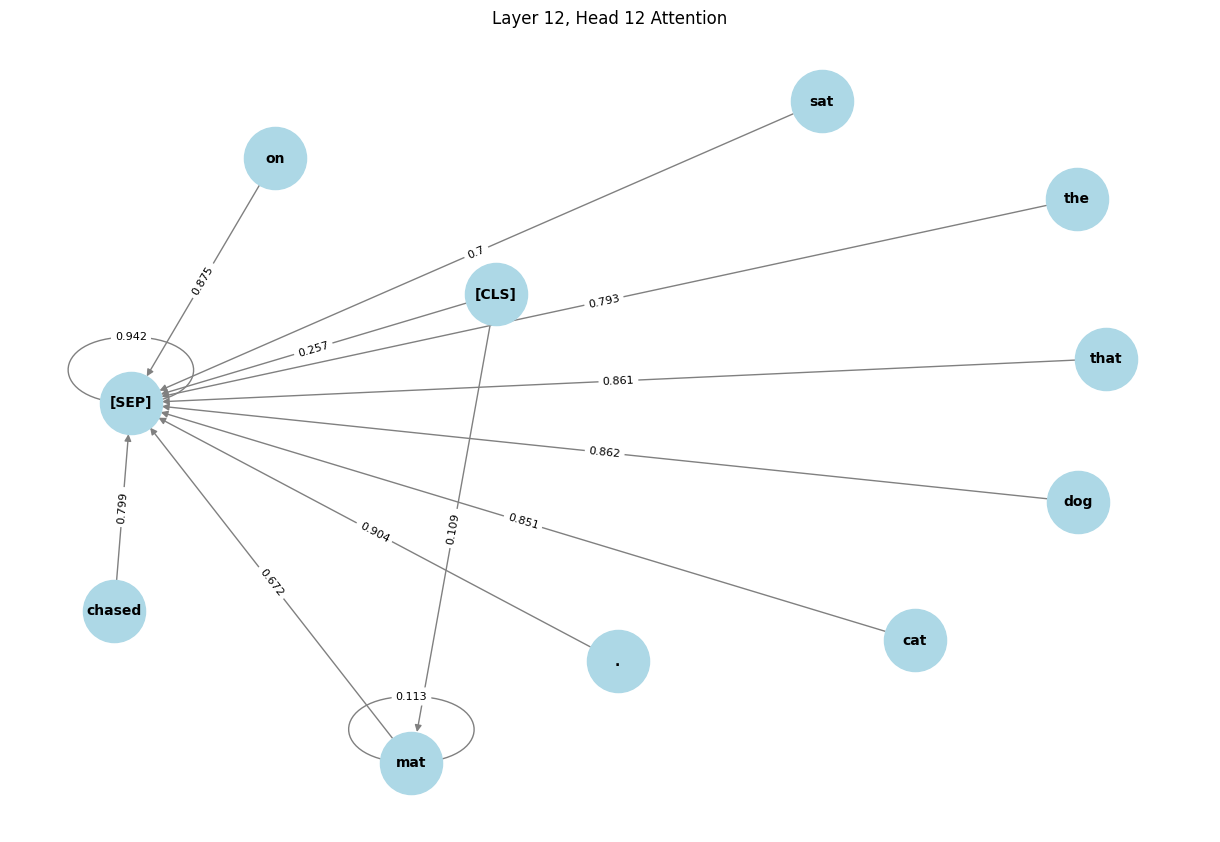

In [7]:
# Select layer and head for visualization
layer = 11  # Last layer (12th layer, 0-based index)
head = 11   # Last head (12th head, 0-based index)

# Get attention matrix for selected layer and head
attention_matrix = attention_weights[layer][0, head].detach().numpy()

# Create and visualize graph
G = build_graph(attention_matrix, tokens_list, threshold=0.1)
visualize_attention(G, title=f"Layer {layer+1}, Head {head+1} Attention")

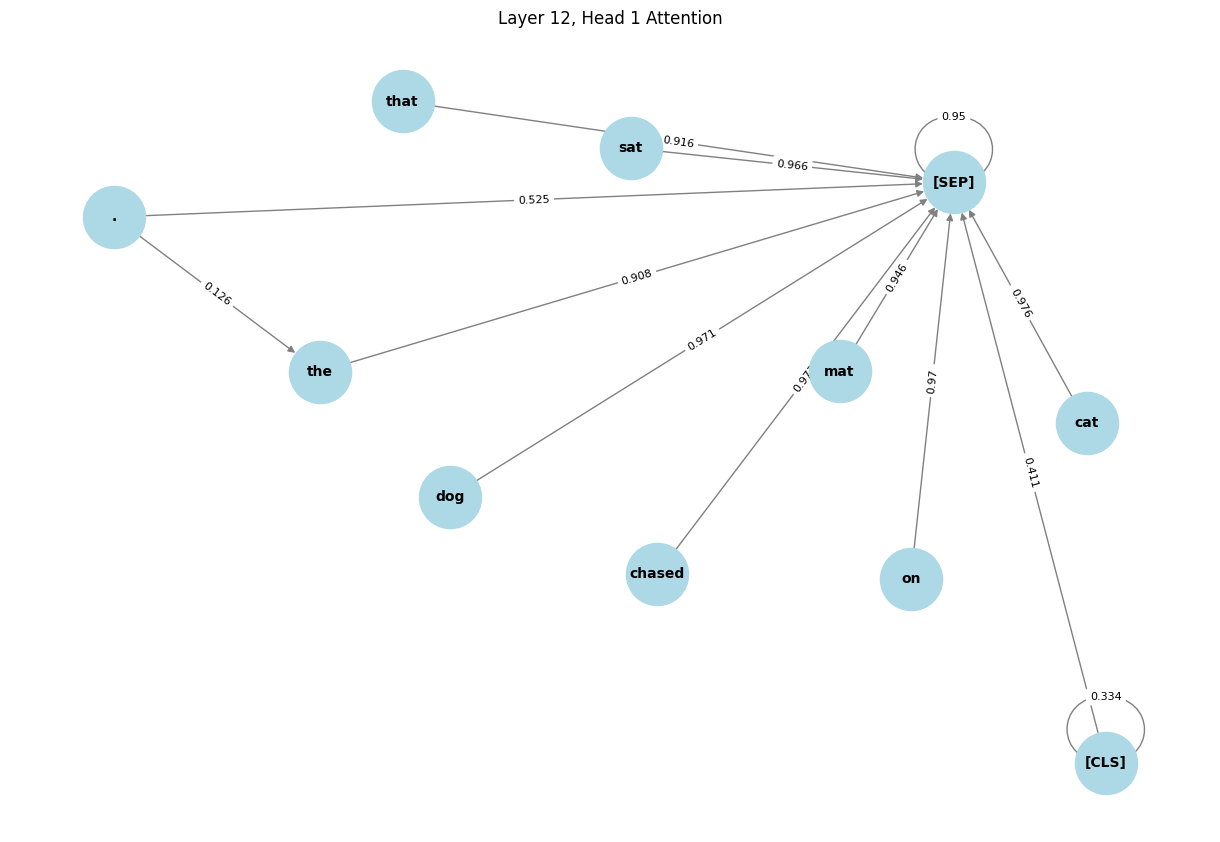

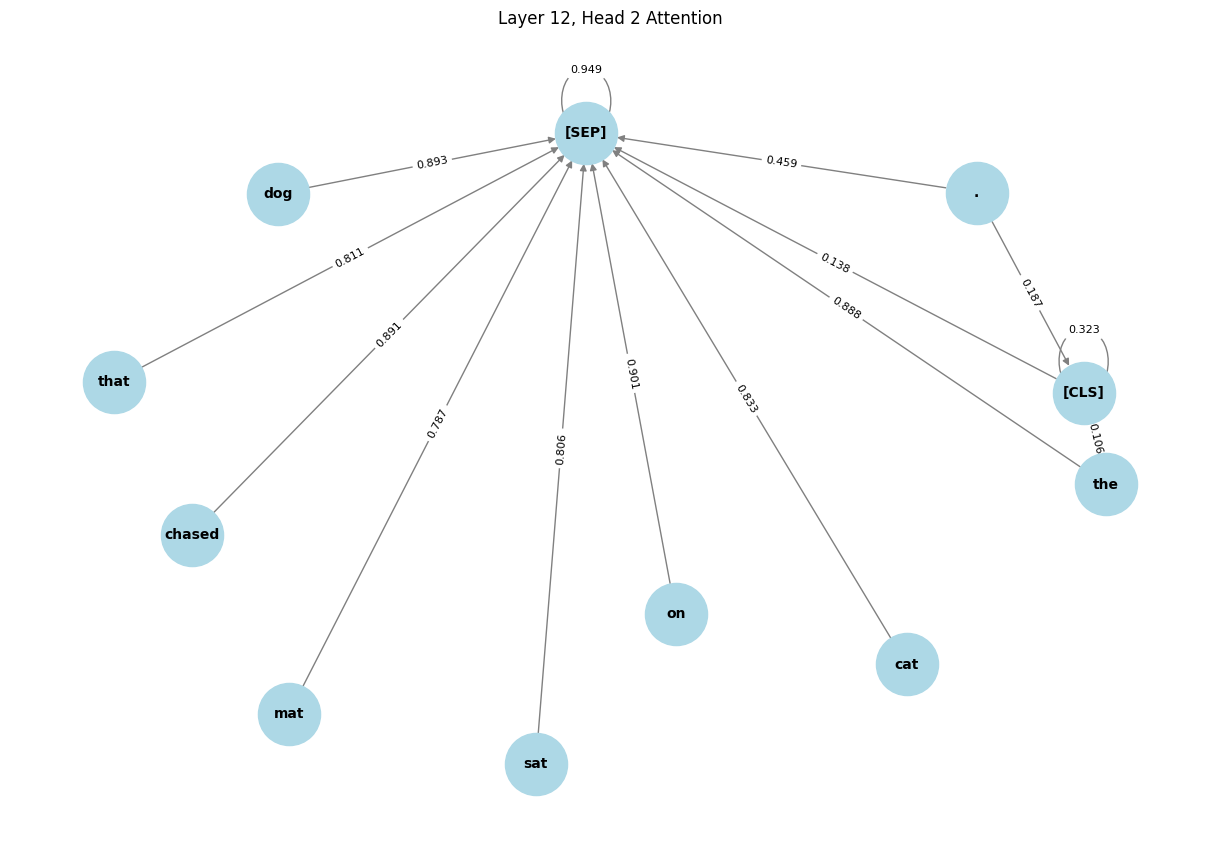

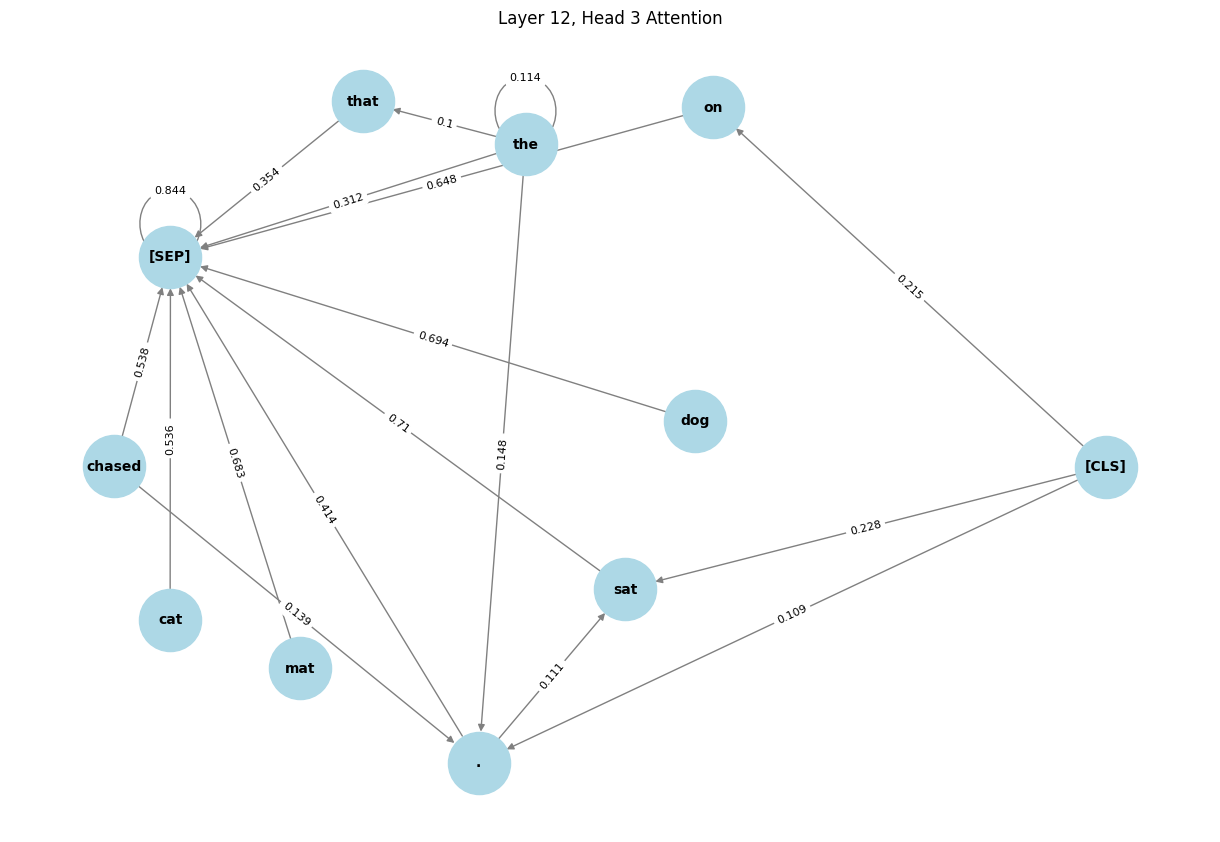

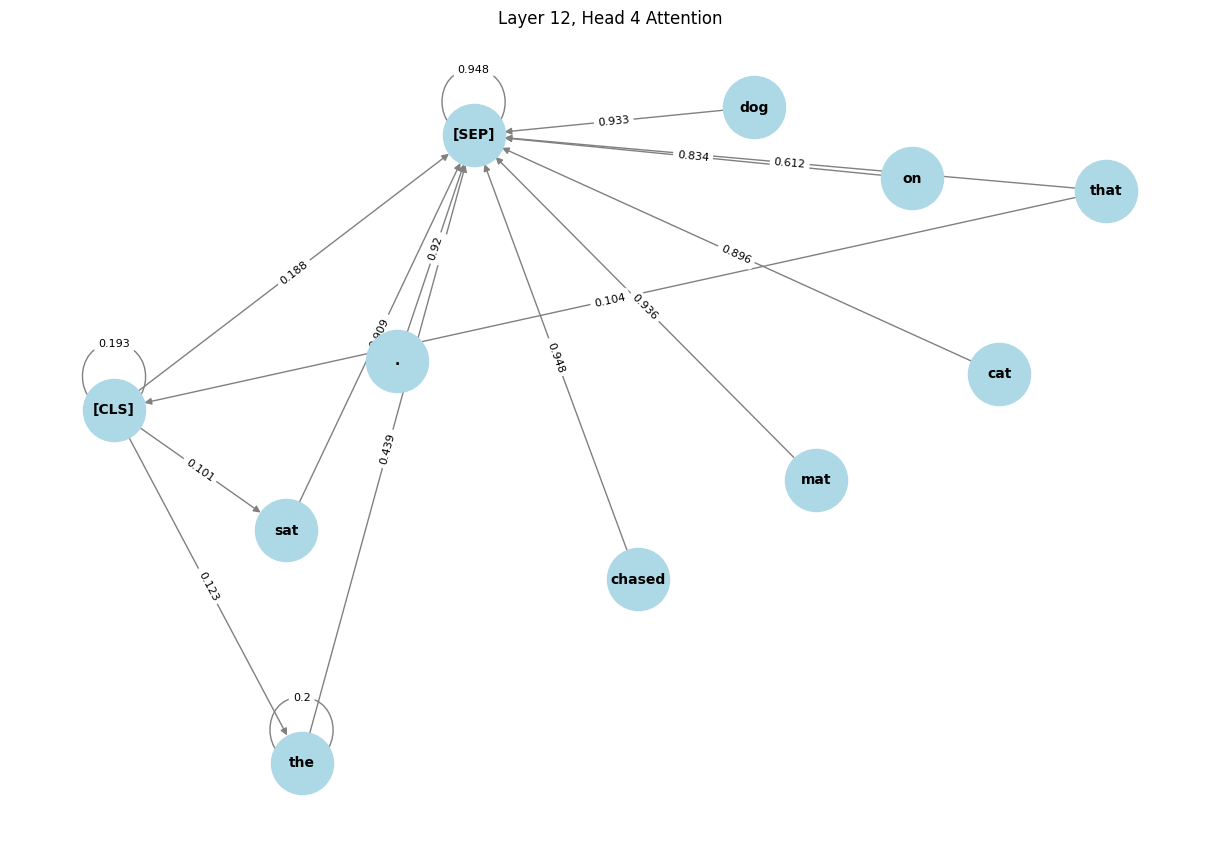

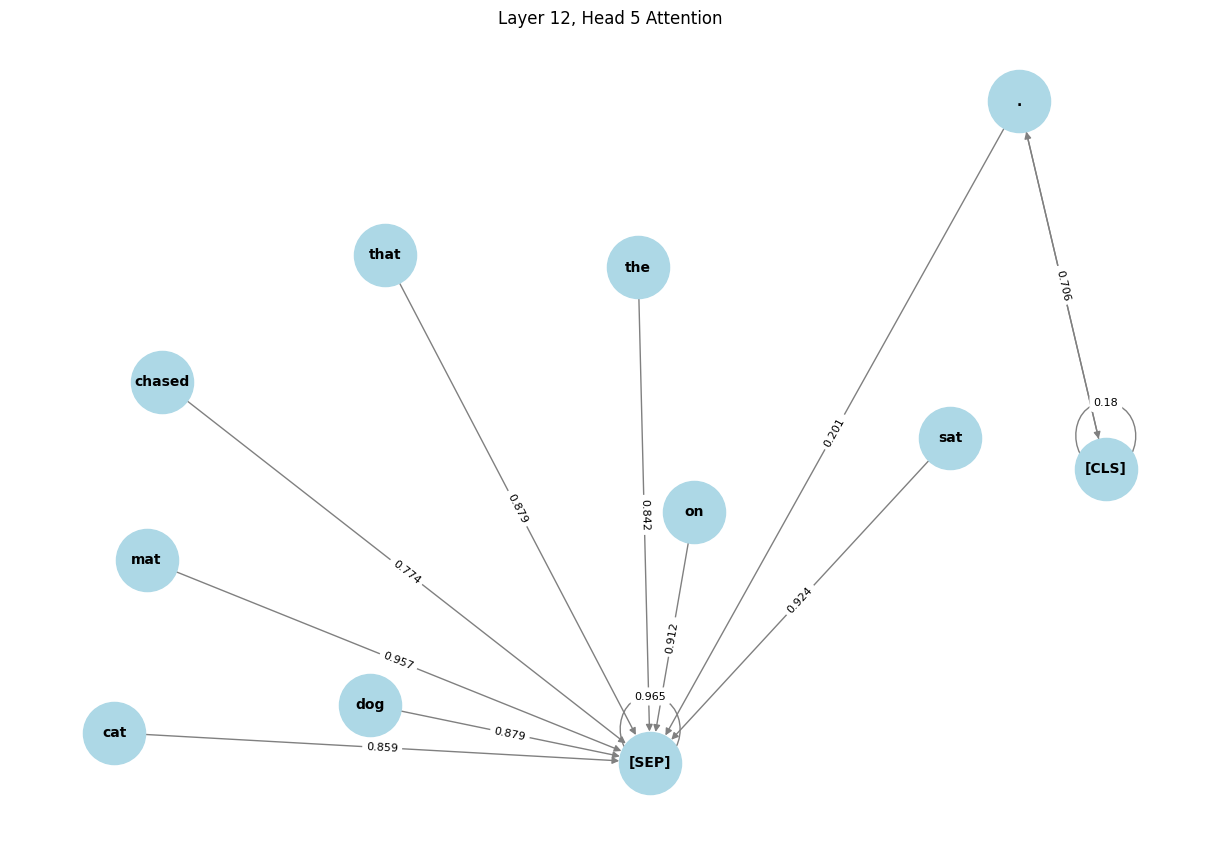

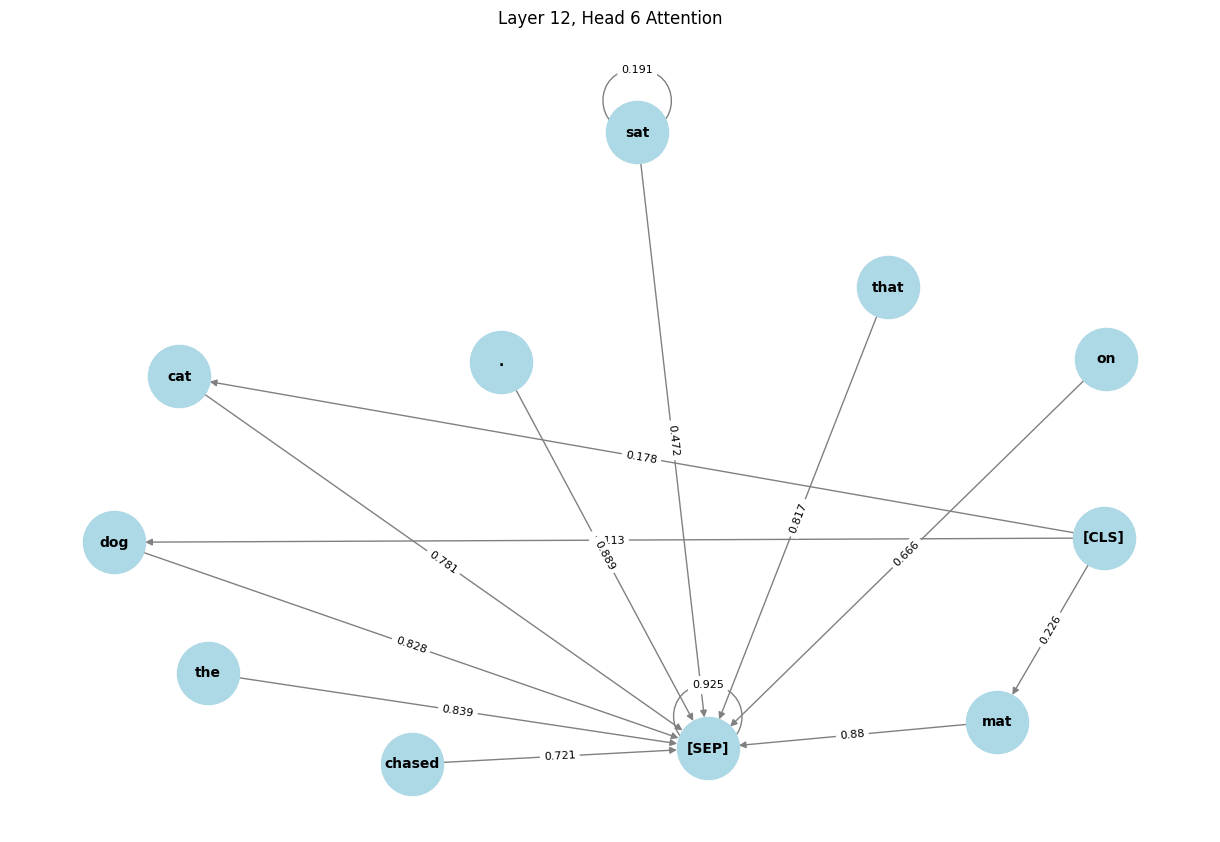

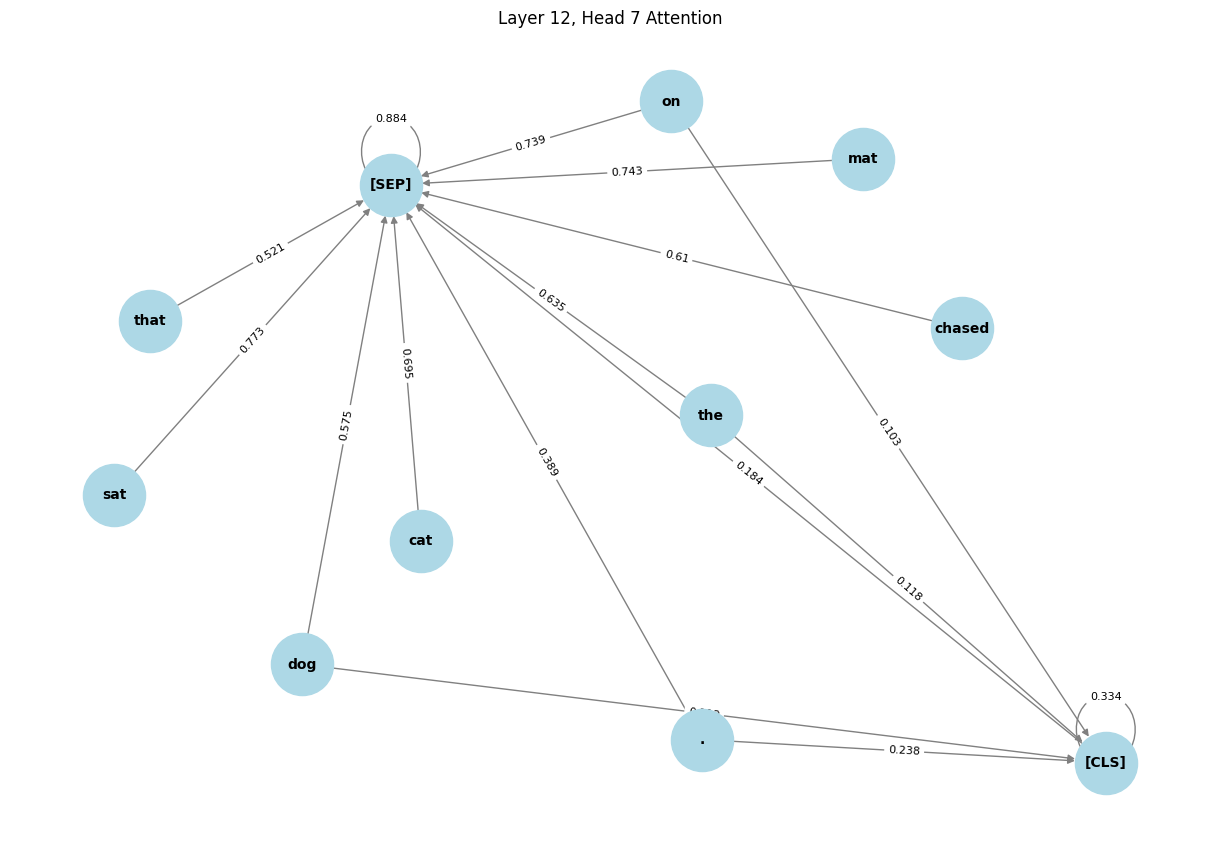

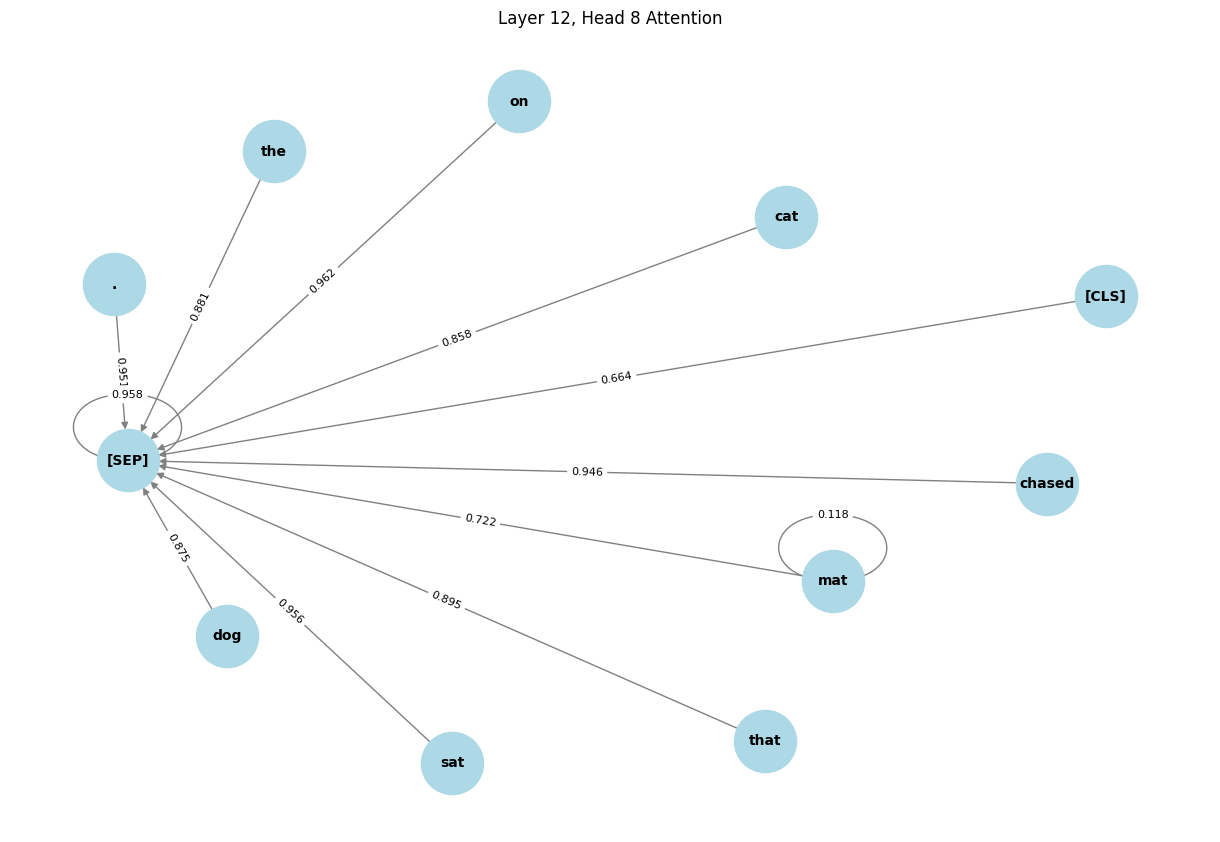

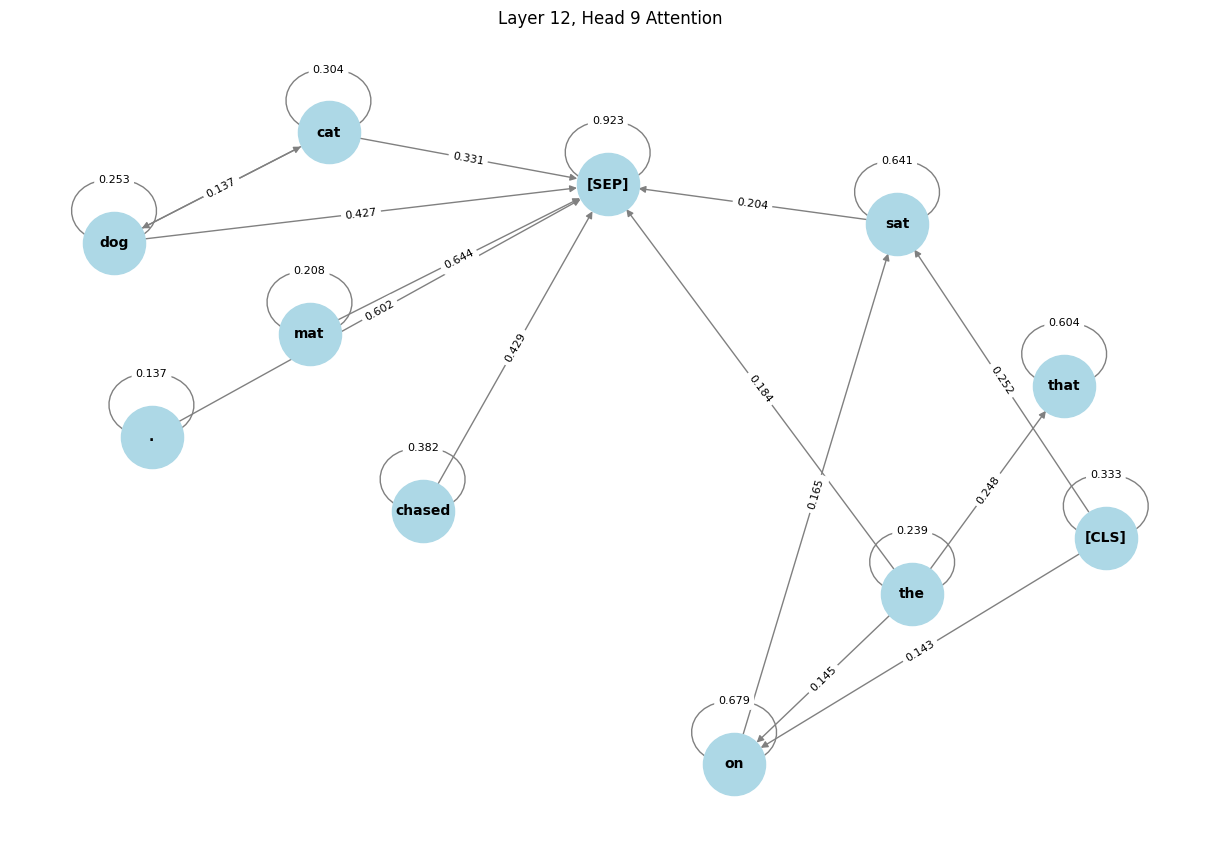

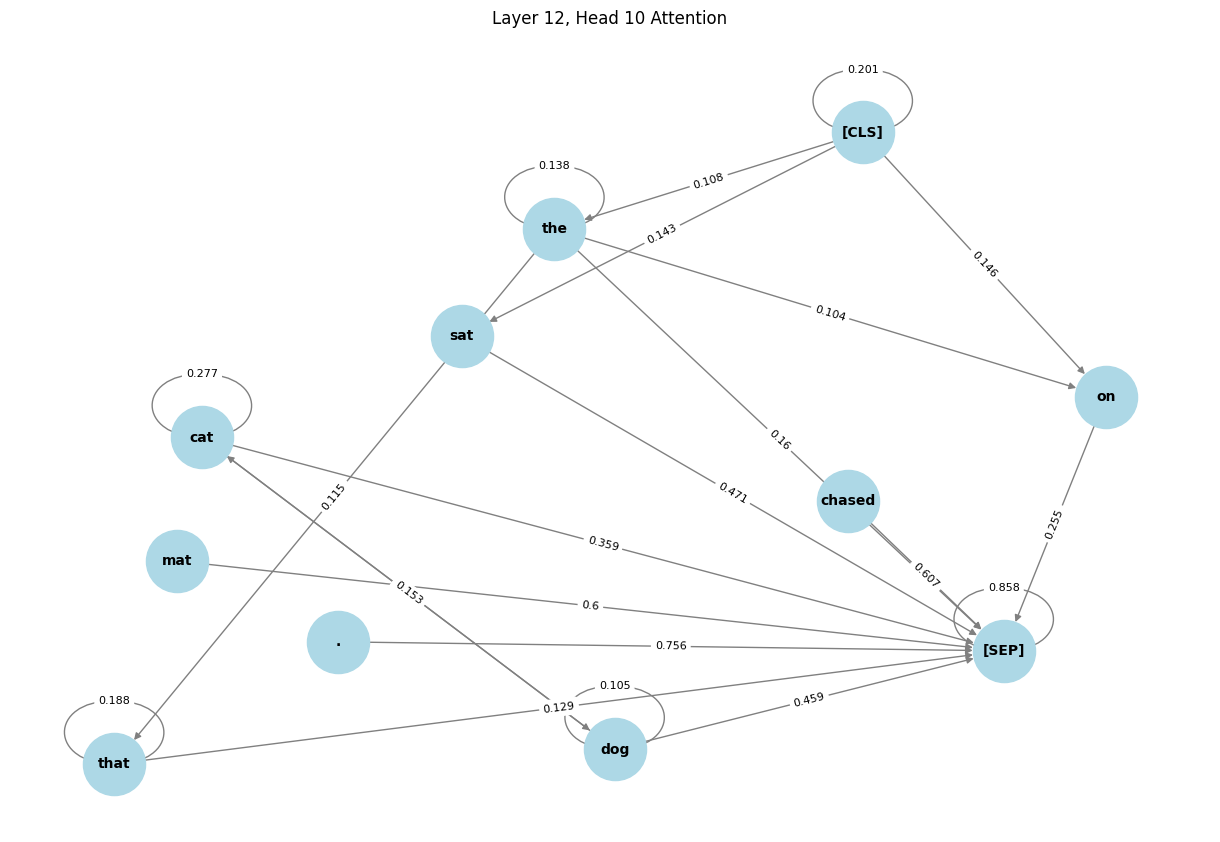

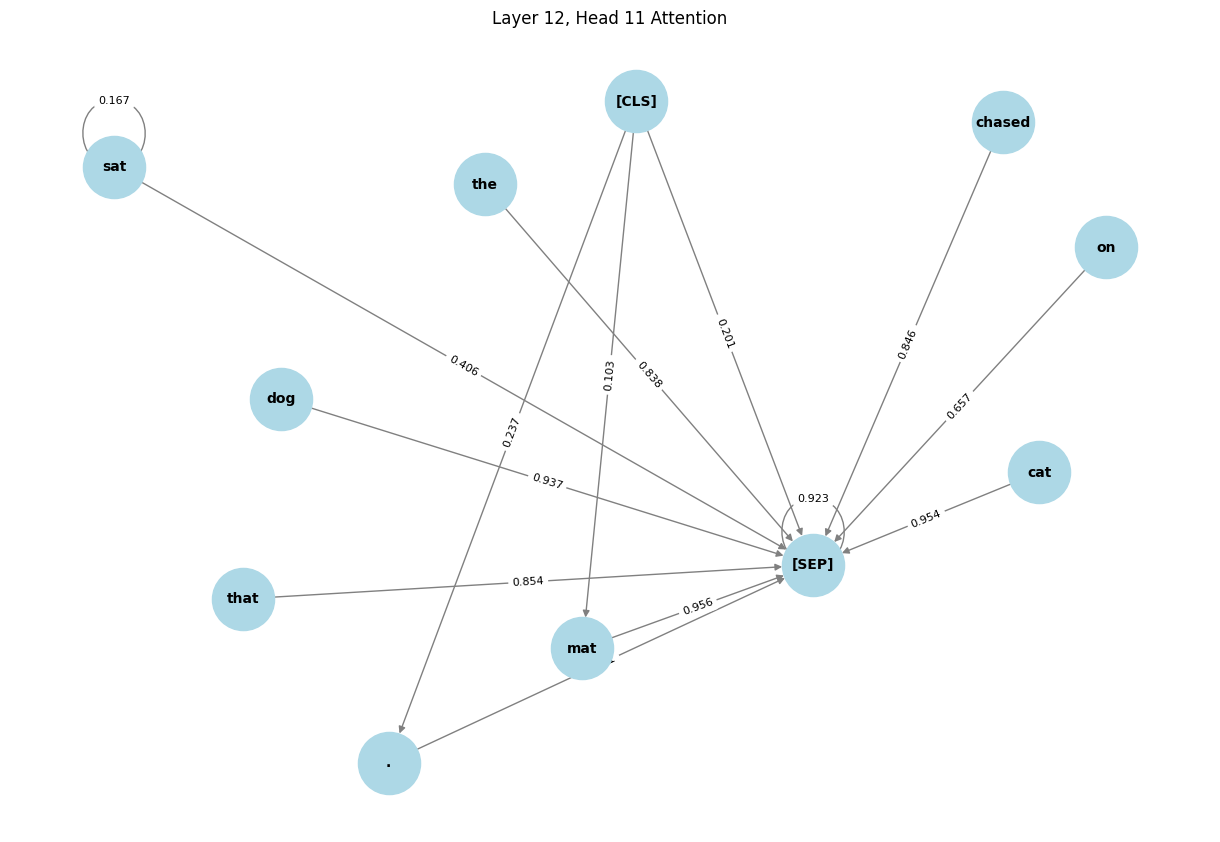

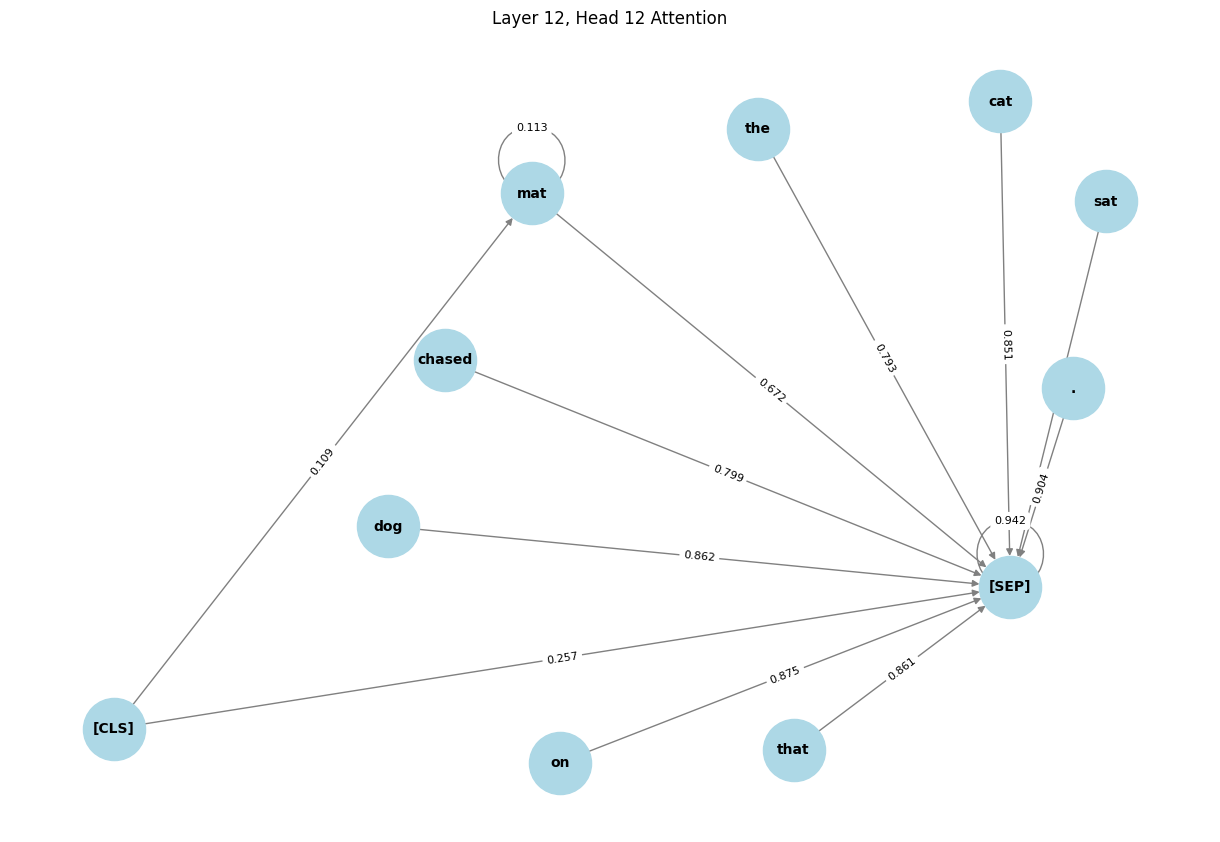


=== Layer 12 cat connections ===
Head 1: [('cat', '[SEP]')]
Head 2: [('cat', '[SEP]')]
Head 3: [('cat', '[SEP]')]
Head 4: [('cat', '[SEP]')]
Head 5: [('cat', '[SEP]')]
Head 6: [('cat', '[SEP]')]
Head 7: [('cat', '[SEP]')]
Head 8: [('cat', '[SEP]')]
Head 9: [('cat', 'cat'), ('cat', 'dog'), ('cat', '[SEP]')]
Head 10: [('cat', 'cat'), ('cat', 'dog'), ('cat', '[SEP]')]
Head 11: [('cat', '[SEP]')]
Head 12: [('cat', '[SEP]')]


In [15]:
num_heads = attention_weights[layer].shape[1]  # get heads number
cat_index = tokens_list.index('cat')  # get cat index

cat_connections = {}

for head in range(num_heads):
    attention_matrix = attention_weights[layer][0, head].detach().numpy()
    G = build_graph(attention_matrix, tokens_list, threshold=0.1)
    
    # get cat connections
    cat_edges = list(G.edges('cat'))
    cat_connections[head] = cat_edges
    
    # visualize Head Attention Graph
    visualize_attention(G, title=f"Layer {layer+1}, Head {head+1} Attention")

# Output cat in Layer 12 connections
print("\n=== Layer 12 cat connections ===")
for head, edges in cat_connections.items():
    print(f"Head {head+1}: {edges}")

In [18]:
attention_scores = {}

# Go through Layers and Heads
for layer in range(len(attention_weights)):
    for head in range(attention_weights[layer].shape[1]):
        # get Attention tensor of the first batch
        # detach from compute graph and convert to numpy 
        attention_matrix = attention_weights[layer][0, head].detach().numpy()
        
        # calculate cat received Attention sum
        cat_attention = attention_matrix[:, cat_index].sum()
        
        attention_from_cat = attention_matrix[cat_index, :]
        max_token_index = attention_from_cat.argmax()
        max_token = tokens_list[max_token_index]
        # Save it in dictionary
        attention_scores[(layer+1, head+1, max_token)] = cat_attention

# Sort on all Attention Scores
sorted_attention = sorted(attention_scores.items(), key=lambda x: x[1], reverse=True)

# output cat Attention
print("\n=== cat Attentions ===")
for (layer, head, max_token), score in sorted_attention:
    print(f"Layer {layer}, Head {head}, Token: {max_token}: Attention Score = {score:.3f}")


=== cat Attentions ===
Layer 9, Head 11, Token: [SEP]: Attention Score = 2.362
Layer 9, Head 8, Token: [SEP]: Attention Score = 2.086
Layer 8, Head 11, Token: [SEP]: Attention Score = 1.816
Layer 4, Head 11, Token: [SEP]: Attention Score = 1.703
Layer 5, Head 11, Token: [SEP]: Attention Score = 1.448
Layer 1, Head 10, Token: cat: Attention Score = 1.401
Layer 1, Head 4, Token: the: Attention Score = 1.373
Layer 7, Head 11, Token: [SEP]: Attention Score = 1.226
Layer 11, Head 11, Token: cat: Attention Score = 1.224
Layer 4, Head 5, Token: [SEP]: Attention Score = 1.126
Layer 7, Head 5, Token: [SEP]: Attention Score = 1.107
Layer 6, Head 4, Token: [SEP]: Attention Score = 1.105
Layer 3, Head 11, Token: cat: Attention Score = 1.089
Layer 4, Head 10, Token: [CLS]: Attention Score = 1.059
Layer 5, Head 1, Token: [SEP]: Attention Score = 1.040
Layer 1, Head 8, Token: dog: Attention Score = 1.032
Layer 11, Head 7, Token: [SEP]: Attention Score = 1.014
Layer 4, Head 6, Token: [CLS]: Attention

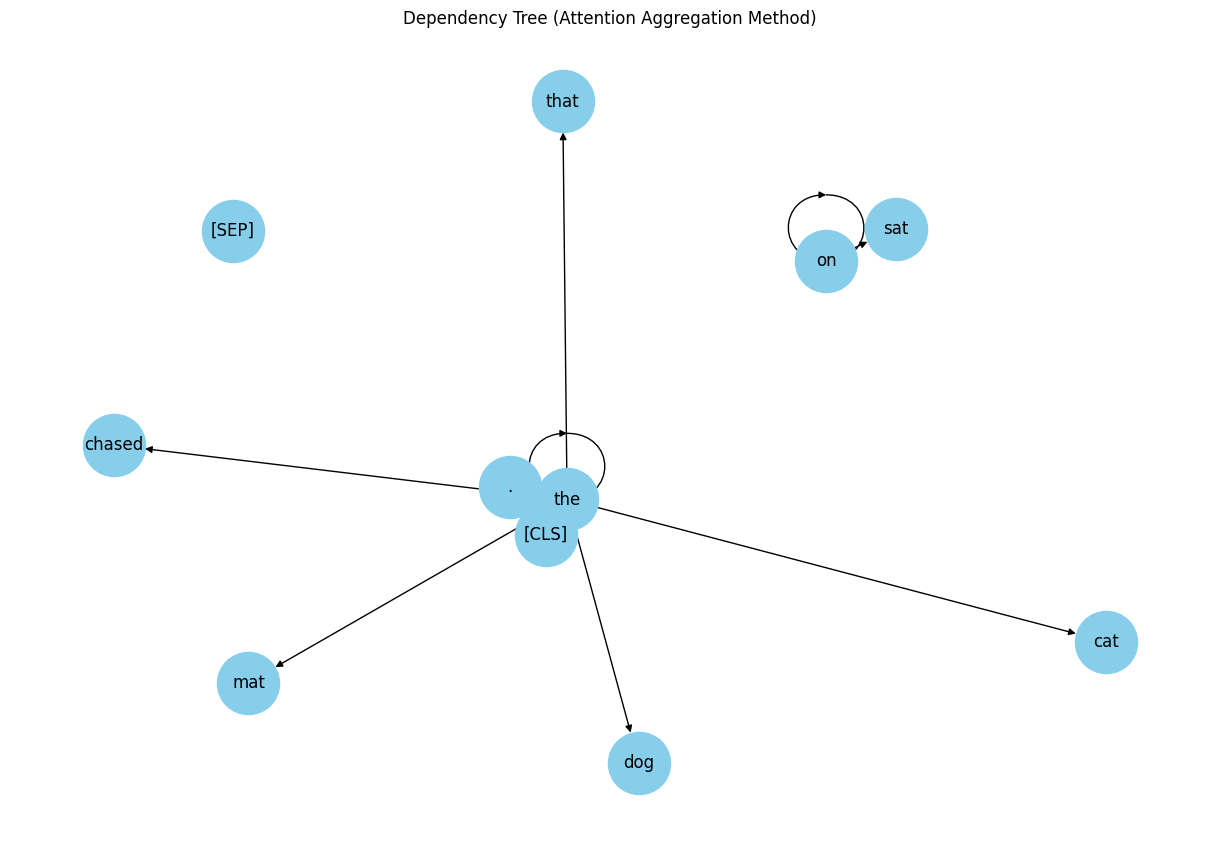


=== Attention Aggregation Dependency ===
the ← .
cat ← the
that ← the
the ← the
dog ← the
chased ← the
sat ← on
on ← on
the ← the
mat ← the
. ← [CLS]


In [19]:

# BERT Rediscovers the Classical NLP Pipeline Tenney et al. 2019
# https://arxiv.org/abs/1905.05950


selected_layers = range(7, 12)  # Layer 8 to Layer 12
aggregated_attention = np.zeros((len(tokens_list), len(tokens_list)))

for layer in selected_layers:
    layer_attention = attention_weights[layer].mean(dim=1).detach().numpy()[0]  # average the heads
    aggregated_attention += layer_attention

# normalize
aggregated_attention /= len(selected_layers)

# find the Attention Dependency Head
dependency_pairs = []

for i, token in enumerate(tokens_list):
    if token in ['[CLS]', '[SEP]']:  # Skip CLS and SEP
        continue
    
    # Get the token with the highest Attention weight 
    max_head_index = np.argmax(aggregated_attention[:, i])
    head_token = tokens_list[max_head_index]
    
    # Add it to the dependency pair
    dependency_pairs.append((head_token, token))

# Define a function to visualize the Dependency Tree
def visualize_dependency_tree(pairs, tokens):
    G = nx.DiGraph()
    G.add_nodes_from(tokens)
    G.add_edges_from(pairs)
    
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=12)
    plt.title("Dependency Tree (Attention Aggregation Method)")
    plt.show()

# Call the function to visualize
visualize_dependency_tree(dependency_pairs, tokens_list)

# Output it
print("\n=== Attention Aggregation Dependency ===")
for head, dependent in dependency_pairs:
    print(f"{dependent} ← {head}")